In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

In [2]:
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [3]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [4]:
data = torch.from_numpy(df.values).float()

print("전체 데이터 : ", data.shape)
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

전체 데이터 :  torch.Size([569, 31])
torch.Size([569, 30]) torch.Size([569, 1])


In [5]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples" % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples


In [6]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index= indices)
y = torch.index_select(y, dim=0, index= indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [7]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

In [8]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

In [9]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid(),
)

model

optimizer = optim.Adam(model.parameters())

In [10]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [11]:
import time

train_history, valid_history = [], []

start = time.time()
for i in range(n_epochs):
    # Shuffle before mini-batch split
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index = indices)
    y_ = torch.index_select(y[0], dim=0, index = indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|

        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)

    # You need to declare to PYTORCH to stop build the computation graph
    with torch.no_grad():
        # You don't need to shuffle the validation set
        # Only split is needed.

        x_ = x[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0)

        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += loss

            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

        #Log each loss to plot after training is done.
        train_history += [train_loss]
        valid_history += [valid_loss]
    
        if(i + 1) % print_interval == 0:
            print('epoch %d/%d : train_loss=%.4e valid_loss=%.4e lowest_loss=%.4e elapsed_time=%.2fsec' % 
                  (i + 1, n_epochs, train_loss, valid_loss, lowest_loss, time.time() - start)
            )
            start = time.time()

        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i

            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print("There is no improvment during last %d epochs." % early_stop)
                break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model
model.load_state_dict(best_model)

epoch 10/10000 : train_loss=1.0805e-01 valid_loss=8.1228e-02 lowest_loss=1.2631e-01 elapsed_time=0.19sec
epoch 20/10000 : train_loss=1.1598e-02 valid_loss=3.1882e-02 lowest_loss=2.1442e-02 elapsed_time=0.15sec
epoch 30/10000 : train_loss=1.0046e-02 valid_loss=3.6857e-02 lowest_loss=2.1442e-02 elapsed_time=0.14sec
epoch 40/10000 : train_loss=6.0036e-03 valid_loss=3.6593e-02 lowest_loss=2.1442e-02 elapsed_time=0.15sec
epoch 50/10000 : train_loss=5.6223e-03 valid_loss=3.8687e-02 lowest_loss=2.1442e-02 elapsed_time=0.20sec
epoch 60/10000 : train_loss=5.1296e-03 valid_loss=3.9984e-02 lowest_loss=2.1442e-02 elapsed_time=0.16sec
epoch 70/10000 : train_loss=3.3709e-03 valid_loss=4.2266e-02 lowest_loss=2.1442e-02 elapsed_time=0.14sec
epoch 80/10000 : train_loss=3.0582e-03 valid_loss=4.2224e-02 lowest_loss=2.1442e-02 elapsed_time=0.15sec
epoch 90/10000 : train_loss=2.9781e-03 valid_loss=4.1224e-02 lowest_loss=2.1442e-02 elapsed_time=0.17sec
epoch 100/10000 : train_loss=2.9411e-03 valid_loss=4.08

<All keys matched successfully>

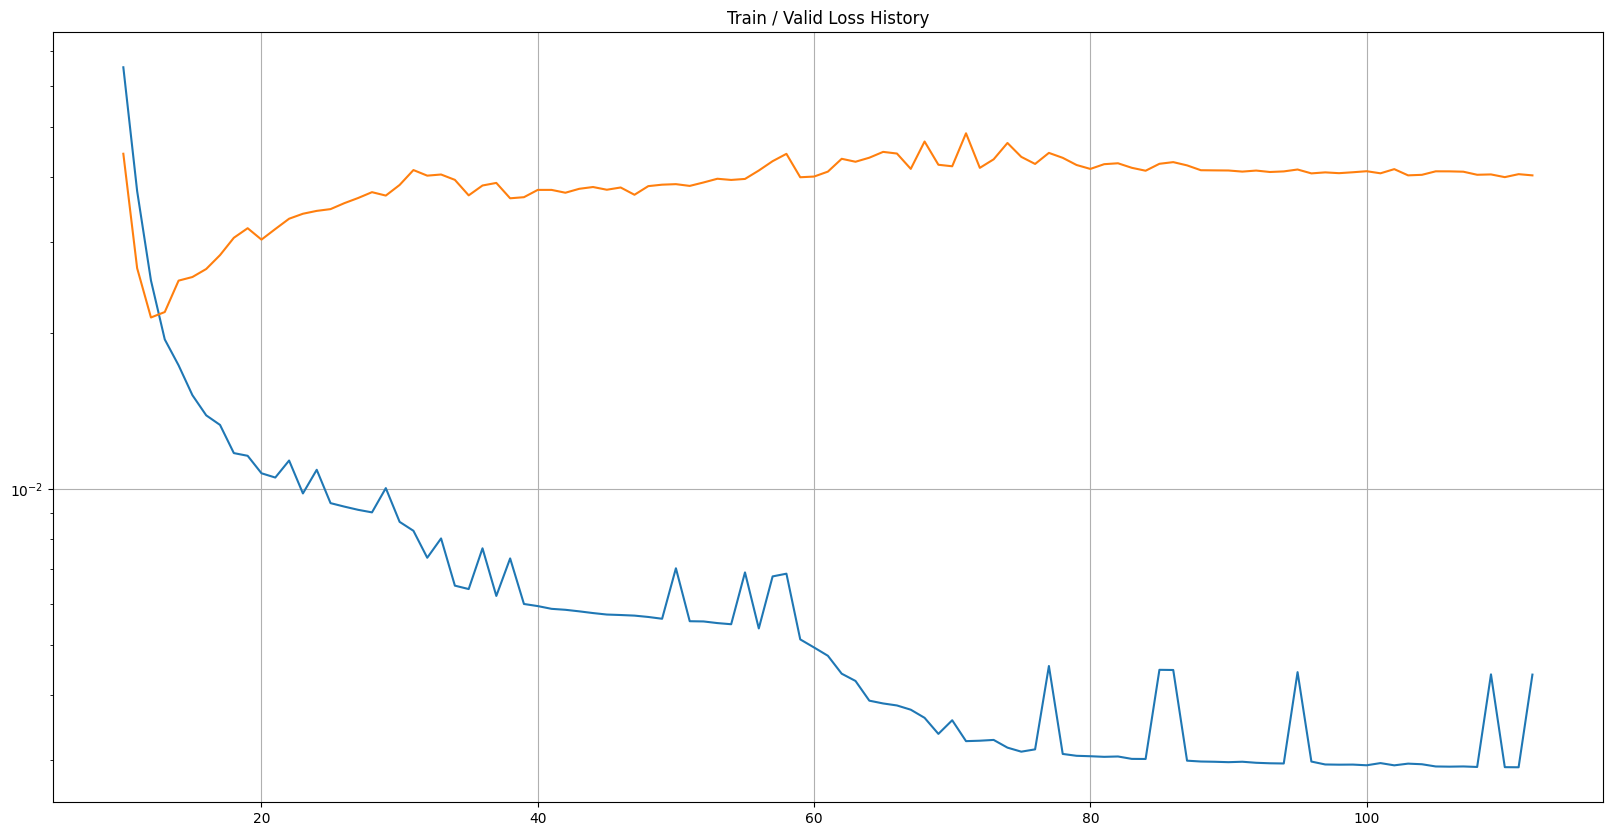

In [12]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train Loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid Loss')
plt.yscale('log')
plt.show()

In [13]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss : %.4e" % sorted_history[0][0])
print("Valid loss : %.4e" % sorted_history[0][1])
print("Test loss : %.4e" % test_loss)


Train loss : 2.5277e-02
Valid loss : 2.1442e-02
Test loss : 2.3039e-02


In [14]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print("Test Accuracy : %.4f" % (correct_cnt / total_cnt))

Test Accuracy : 0.9826


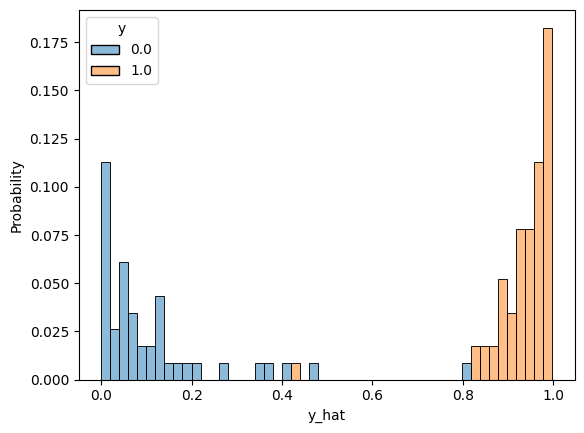

In [15]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:, 0], df.values[: ,1])

np.float64(0.9993698802772527)